# TP 2: Approximate Variational Inference

During this session, we will first continue the regression experiments started last week by introducing MCDropout variational inference on the sinusoidal toy dataset. Then, we will explore and compare variational approaches, including 'brute-force' mean-field approximation with Pyro library and MCDropout approximation with Logistic Regression on a 2D binary classification dataset.

**Goal**: Take hand on approximate variational inference methods and understand how it works

**Requirements**: 
- Pytorch library:
`pip install torch torchvision`
- Pyro library:
`pip install pyro-ppl`

NB: if you don't have root access on the computer, add `--user` to install the library locally.

## Part I: MC Dropout variational inference in regression

We expand last week's analysis on non-linear models for Bayesian regression. Here, we will define and use a Bayesian Neural Network with MCDropout variational inference to estimate uncertainty on a sinusoidal toy dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F
from IPython import display

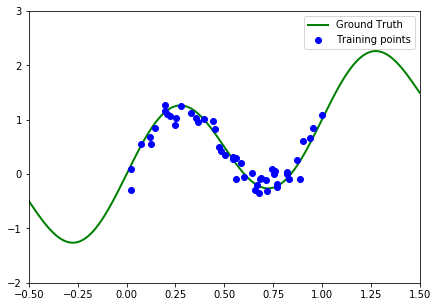

In [2]:
# Generate sinusoidal toy dataset
def f_sinus(x, noise_amount, sigma=0.2):
    y = np.sin(2*np.pi*x) + x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount * noise

sigma = 0.1
nbpoints = 50

# Create training and test points
dataset_sinus = {}
dataset_sinus['X_train'] = np.random.uniform(0, 1, nbpoints)
dataset_sinus['y_train'] = f_sinus(dataset_sinus['X_train'], noise_amount=1)
dataset_sinus['X_test'] = np.linspace(-0.5,1.5, 10*nbpoints)
dataset_sinus['y_test'] = f_sinus(dataset_sinus['X_test'], noise_amount=0)

# Hyperparameters
dataset_sinus['ALPHA'] = 0.01
dataset_sinus['BETA'] = 1/(2.0*sigma**2)

# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmin =-0.5, xmax = 1.5)
plt.ylim(ymin = -2, ymax = 3)
plt.plot(dataset_sinus['X_test'], dataset_sinus['y_test'], color='green', linewidth=2,
         label="Ground Truth")
plt.plot(dataset_sinus['X_train'], dataset_sinus['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

In [3]:
X_train_tensor = torch.from_numpy(dataset_sinus['X_train'].copy()).float().unsqueeze(dim=1)
y_train_tensor = torch.from_numpy(dataset_sinus['y_train'].copy()).float()
X_test_tensor = torch.from_numpy(dataset_sinus['X_test'].copy()).float().unsqueeze(dim=1)

In [4]:
# Useful function: plot results
def plot_results(X_train, y_train, X_test, y_test, y_pred, std_pred,
                 xmin=-2, xmax=2, ymin=-2, ymax=1, stdmin=0.30, stdmax=0.45):
    """Given a dataset and predictions on test set, this function draw 2 subplots:
    - left plot compares train set, ground-truth (test set) and predictions
    - right plot represents the predictive variance over input range
    
    Args:
      X_train: (array) train inputs, sized [N,]
      y_train: (array) train labels, sized [N, ]
      X_test: (array) test inputs, sized [N,]
      y_test: (array) test labels, sized [N, ]
      y_pred: (array) mean prediction, sized [N, ]
      std_pred: (array) std prediction, sized [N, ]
      xmin: (float) min value for x-axis on left and right plot
      xmax: (float) max value for x-axis on left and right plot
      ymin: (float) min value for y-axis on left plot
      ymax: (float) max value for y-axis on left plot
      stdmin: (float) min value for y-axis on right plot
      stdmax: (float) max value for y-axis on right plot
      
    Returns:
      None
    """
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = ymin, ymax = ymax)
    plt.plot(X_test, y_test, color='green', linewidth=2,
             label="Ground Truth")
    plt.plot(X_train, y_train, 'o', color='blue', label='Training points')
    plt.plot(X_test, y_pred, color='red', label="MC dropout")
    plt.fill_between(X_test, y_pred-std_pred, y_pred+std_pred, color='indianred', label='1 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*2, y_pred-std_pred, color='lightcoral')
    plt.fill_between(X_test, y_pred+std_pred*1, y_pred+std_pred*2, color='lightcoral', label='2 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*3, y_pred-std_pred*2, color='mistyrose')
    plt.fill_between(X_test, y_pred+std_pred*2, y_pred+std_pred*3, color='mistyrose', label='3 std. int.')
    plt.legend()

    plt.subplot(122)
    plt.title("Predictive variance along x-axis")
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = stdmin, ymax = stdmax)
    plt.plot(X_test, std_pred**2, color='red', label="\u03C3² {}".format("Pred"))

    # Get training domain
    training_domain = []
    current_min = sorted(X_train)[0]
    for i, elem in enumerate(sorted(X_train)):
        if elem-sorted(X_train)[i-1]>1:
            training_domain.append([current_min,sorted(X_train)[i-1]])
            current_min = elem
    training_domain.append([current_min, sorted(X_train)[-1]])
    
    # Plot domain
    for j, (min_domain, max_domain) in enumerate(training_domain):
        plt.axvspan(min_domain, max_domain, alpha=0.5, color='gray', label="Training area" if j==0 else '')
    plt.axvline(X_train.mean(), linestyle='--', label="Training barycentre")   
    
    plt.legend()
    plt.show()

In [6]:
# Useful function: plot and show learning process in regression
def plot_learning_process(X_train_tensor, y_train_tensor, outputs, loss, epoch):
    """Given 1D training input and prediction vector, this function output a plot of 
    the predicted function and value of the loss, both updated at each epoch.

    Args:
      X_train_tensor: (tensor) train inputs, sized [N,1]
      y_train_tensor: (tensor) train labels, sized [N, ]
      output: (tensor) prediction vector from NN, sized [N, ]
      loss: (float) current loss value
      epoch: (int) current epoch
      
    Returns:
      None
    """
    plt.cla()
    ax.set_title('Regression Analysis')
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(-2, 3)
    ax.scatter(X_train_tensor.data.numpy(), y_train_tensor.data.numpy(), color = "orange")
    ax.plot(X_train_tensor.sort(0).values.data.numpy(), output[X_train_tensor.sort(0).indices].data.numpy(), 'g-', lw=3)
    ax.text(1.0, 0.3, 'Step = %d' % epoch, fontdict={'size': 20, 'color':  'red'})
    ax.text(1.0, 0, 'Loss = %.4f' % loss, fontdict={'size': 20, 'color':  'red'})
    display.display(plt.gcf())
    display.clear_output(wait=True)

**Question 1.1: Code a Multi-Layer Perceptron, a neural network with one hidden layer, and add a Dropout Layer with p=0.25.**

In [7]:
#TO DO: Code MLP with 1 hidden layer and a dropout layer. Be careful, the dropout layer should be also activated 
#during test time.
#(Hint: we may want to look out at F.dropout())

class MLP(nn.Module):
    """ Pytorch MLP model with an added dropout layer"""
    def __init__(self, hidden_size):
        super().__init__()
        self.l1=nn.Linear(1,hidden_size)
        self.l2=nn.Linear(hidden_size,1)
        self.relu=nn.ReLU()
    def forward(self, x):
        res=self.l1(x)
        res =self.relu(res)
        res=nn.functional.dropout(res,p=0.25)
        res=self.l2(res)
        return res

In [8]:
net = MLP(hidden_size=100)
net.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-6)

**Question 1.2: Train the model for 5000 epoch, batch size equals to training set. Use ``plot_learning_process()`` to visualize training.**

Finished Training


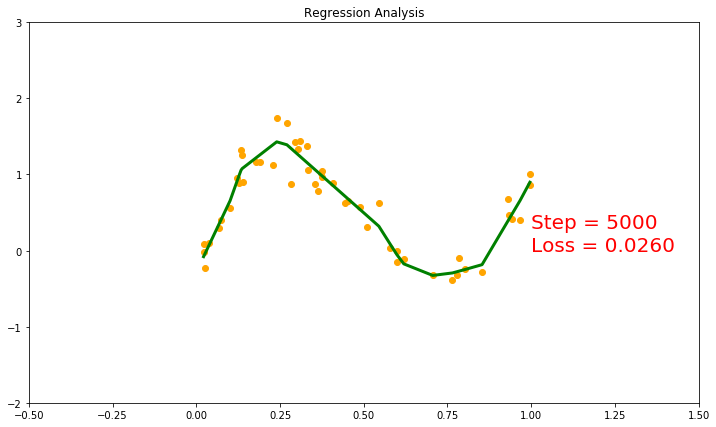

In [8]:
#TO DO: Train MLP for 5000 epochs

fig, ax = plt.subplots(figsize=(12,7))

# To DO here
for epoch in range(5000):
    output=net(X_train_tensor).reshape(-1)
    loss=criterion(output,y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1)%100==0:
        plot_learning_process(X_train_tensor, y_train_tensor, output, loss.data.numpy(), epoch+1)

print('Finished Training')

**Question 1.3: Predict on test set using s=1000 samples and visualize results. What can you say about the predictive variance?**

9.987662e-06
49.99999999999999


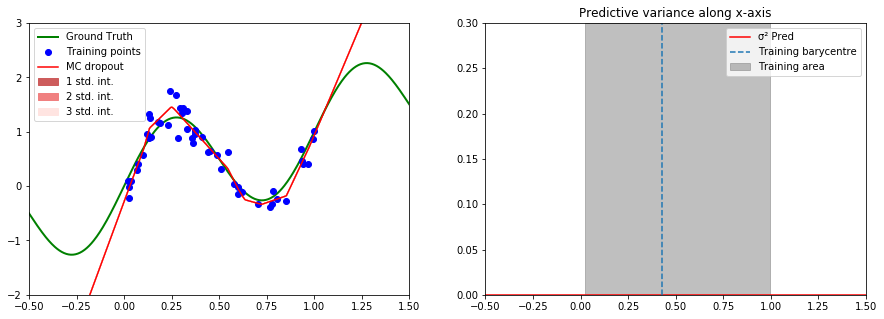

In [9]:
#TO DO: Predict on test set and visualize results using plot_results

net.eval()
net.training = True
res = []
for _ in range(1000):
    res.append(net(X_test_tensor).detach().numpy())

res = np.array(res).reshape((1000,500))
mean = np.mean(res, axis=0)
std = np.std(res, axis=0)# + dataset_sinus['BETA']
print(np.mean(std))
print(dataset_sinus['BETA'])
# For plotting using, uncomment the following function (need to have compute y_pred and std_pred)
plot_results(dataset_sinus['X_train'], dataset_sinus['y_train'], dataset_sinus['X_test'], dataset_sinus['y_test'],
             mean, std, xmin=-0.5, xmax=1.5, ymin=-2, ymax=3, stdmin=0, stdmax=0.3)

## Part II: Bayesian Logistic Regression

In previous linear regression, our model prediction is of the continuous form $f(x)=wTx+b$.

For classification, we wish to predict discrete class labels $\mathcal{C}_k$ to a sample $x$. 
Let's consider here binary classification:
$$f(x) = \sigma(w^T x + b)$$
where $\sigma(t)= \frac{1}{1+\exp(t)}$ is the sigmoid function.

As in linear regression, we define a Gaussian prior: 
$$ p(w) = \mathcal{N}(w \vert \mu_0, \Sigma_0) $$
Unfortunately, the posterior distribution isn't tractable as the likelihood isn't conjugate to the prior anymore.

We will explore in the following different methods to obtain an estimate of the posterior distribution and hence the predictive distribution.

In [2]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F
from IPython import display

In [3]:
# Toy dataset
X, y = make_blobs(n_samples=100, centers=[(-2,-2),(2,2)], cluster_std=0.80, n_features=2)
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)
torch_train_dataset = data.TensorDataset(X,y) # create your datset
train_dataloader = data.DataLoader(torch_train_dataset, batch_size=len(torch_train_dataset))


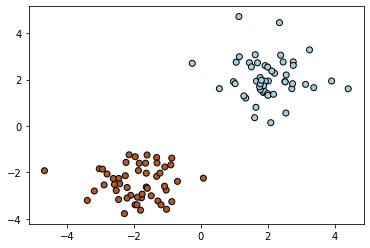

In [11]:
# Visualize dataset
plt.scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')

In [30]:
# Useful function: plot and show learning process in classification
def plot_decision_boundary(model, X, Y, epoch, accuracy, model_type='classic', samples=100, nbh=2, cmap='RdBu', dbg=False):    
    h = 0.02*nbh
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min*2, x_max*2, h),
                         np.arange(y_min*2, y_max*2, h))
    
    test_tensor = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.float32)
    if model_type=='classic':
        model.eval()
        pred = model(test_tensor)
    elif model_type=='svi':
        pred = model.forward(test_tensor, n_samples=samples).mean(0)
    elif model_type=='mcdropout':
        model.eval()
        model.training = True
        outputs = torch.zeros(samples, test_tensor.shape[0], 1)
        for i in range(samples):
            outputs[i] = model(test_tensor)
        pred = outputs.mean(0).squeeze()
    Z = pred.reshape(xx.shape).detach().numpy()
    if dbg:
        plt.imshow(Z)
        plt.colorbar()
        plt.plot()
    else:
        plt.cla()
        ax.set_title('Classification Analysis')
        #ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
        #ax.contour(xx, yy, Z, colors='k', linestyles=':', linewidths=0.7)
        ax.scatter(xx, yy)
        #ax.scatter(X[:,0], X[:,1], c=Y, cmap='Paired_r', edgecolors='k');
        ax.text(-4, -7, f'Epoch = {epoch+1}, Accuracy = {accuracy:.2%}', fontdict={'size': 12, 'fontweight': 'bold'})
        display.display(plt.gcf())
        display.clear_output(wait=True)

### II.1 First solution: MAP estimate

Here, we reduce our posterior distribution $p(w | D)$ to a point estimate $w_{MAP}$ in order to be able to approximate the predictive distribution as:
$$ p(y^* = 1|x^*,D) = \int p(y^* =1 |x^*,w)p(w | D)dw \approx p(y^* =1 |x^*,w_{MAP}) $$
This approximation is called the **plug-in approximation**.

The point estimate corresponds to the Maximum A Posteriori given by:
$$ w_{MAP} = arg \max_w p(w \vert Y,X) = arg \max_w p(Y \vert X,w)p(w) $$
In case of a Gaussian prior, we further obtain:
$$ w_{MAP} = arg \min_w \sum_{n=1}^N \big ( -y_n \log \sigma(w^T x_n + b) - (1-y_n) \log (1 - \sigma(w^T x_n + b)) + \frac{1}{2 \Sigma_0^2} \vert \vert w \vert \vert_2^2 \big ) $$

Note that:
- We recover our usual **cross-entropy** in classification with a weight decay regularization
- Unlike in linear regression $w_{MAP}$ **cannot be computed analytically**
- Optimization methods can however be used to compute it, e.g. **stochastic gradient descent**
- The main disadvantage is we cannot obtain a distribution over w


As a consequence, **the objective is simply to implement and train a Logistic Regression model** with Pytorch and then compute $p(y^* = 1|x^*,D)$ as in a deterministic model.

**Question 2.1: Code Logistic Regression model class in Pytorch below**

In [13]:
#TO DO: Code Logistic Regression in Pytorch

class LogisticRegression(nn.Module):
    """ A D-dimension Logistic Regression Model in Pytorch"""
    def __init__(self, D):
        super().__init__()
        self.l = nn.Linear(D, 1)
        self.sigmoid=nn.Sigmoid()
        
    def forward(self, x):
        x = self.l(x)
        x = self.sigmoid(x)
        return x

In [14]:
net = LogisticRegression(D=2)
net.train()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.1, weight_decay=1e-6)

**Question 2.2:  Train Logistic Regression with gradient descent for 20 epochs in code below**

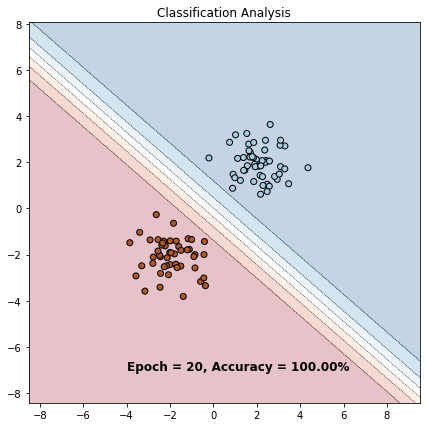

In [16]:
#TO DO: Train Logistic Regression with gradient descent for 20 epochs

fig, ax = plt.subplots(figsize=(7,7))
for epoch in range(20):
    for bx, by in train_dataloader:
        print(bx.dtype, by.dtype)
        output = net(bx).reshape(-1)
        print(output.dtype)
        loss = criterion(output,by)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    

    # For plotting and showing learning process at each epoch, uncomment and indent line below
    plot_decision_boundary(net, X, y, epoch, ((output.squeeze()>=0.5) == y.bool()).float().mean(), model_type='classic')

**Question 2.3: Analyze the results showed on plot. Looking at $p(y=1 | x, w_{MAP})$, what can you say about points far from train distribution?**

### II.2 Second solution: Variational Inference

Here, we define an approximating variational distribution $q_\theta(w)$ parametrized by $\theta$ and minimize its KL divergence with the unknown true posterior $p(w \vert D)$. This is equivalent to maximizing the **evidence lower bound (ELBO)** w.r.t to $q_\theta(w)$:
$$ L_{VI}(\theta) = \sum_i \int q_\theta (w) \log p(y_i \vert x_i, w) dw - KL(q_\theta(w) \vert\vert p(w)) $$

As we chose a Gaussian prior $p(w)$, we also define $q_\theta(w)$ as a Gaussian distribution.

The predictive distribution can then be approximated using **Monte Carlo sampling**:
$$ p(y^*=1|x^*,D) \approx \int p(y^*=1|x^*,w)q_\theta^*(w) \approx \frac{1}{S} \sum_{s=1}^S p(y^*=1|x^*,w_s) $$
where $w_s \sim q^*_\theta(w)$ are samples from the optimum variational distribution.

In this part, we use [Pyro](https://pyro.ai/) library to construct our VI approach. Pyro is a tool for deep probabilistic modeling and supported by PyTorch on the backend.

Remind that we defined our Logistic regression model as $f(x) = \sigma(w^T x + b)$ where $\sigma(t)= \frac{1}{1+\exp(t)}$ is the sigmoid function. As such, we need to place Gaussian distributions on parameters $w$ and $b$.

In [8]:
import pyro 
from pyro import poutine
import pyro.optim as pyroopt
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from torch.distributions import constraints

**Question 2.4: Implement Bayesian Logistic Regression model with variational inference in Pyro by completing the code below**

In [16]:
#TO DO: Complete code in guide() method below

class BayesianLogRegModel(nn.Module):
    ''' Pyro model class that contains model and guide definition which will be pass to pyro.infer.SVI() function.
    We also define infer_parameters() to train the SVI model and forward() to compute predictions
    '''
    def __init__(self, D):
        ''' Initialize hyparameters for priors and for variational parameters '''
        super(BayesianLogRegModel, self).__init__()
        # hyperparameters for normal priors
        self.w_0_prior_loc = torch.zeros(1, D)
        self.w_0_prior_scale = torch.ones(1, D)
        self.b_0_prior_loc = torch.zeros(1)
        self.b_0_prior_scale = torch.ones(1)
        
        # initial values of variational parameters
        self.w_0_loc = torch.zeros((1, D)).double()
        self.w_0_scale = torch.ones((1, D)).double()
        self.b_0_loc = torch.zeros((1,)).double()
        self.b_0_scale = torch.ones((1,)).double()

    def model(self, x, y):
        ''' We define the stochastic programming (graph) of our model. It contains pyro.sampling statements 
        to represent random variables'''
        # Sample from prior
        w = pyro.sample("weight", dist.Normal(self.w_0_prior_loc, self.w_0_prior_scale).independent(1))
        b = pyro.sample("bias", dist.Normal(self.b_0_prior_loc, self.b_0_prior_scale).independent(1))

        with pyro.iarange("data", x.size(0)):
            # Define model graph
            model_logits = (torch.matmul(x, w.T.type(torch.float32)) + b).squeeze()  
            # Sample output logits
            pyro.sample("obs", dist.Bernoulli(logits=model_logits), obs=y.squeeze())
            
    def guide(self, x, y=None):
        ''' Encoded as a stochastic function, the guide serves to define the variational 
        posterior distribution. It contains pyro.param statements which represents our learnable theta parameters 
        and pyro.sampling statements for random variables in a mirror way of the model. These names will be used to align the random 
        variables in the model and guide'''
        # Set-up weight (w) parameters to be optimized to approximate the true posterior
        w_loc = pyro.param("w_loc", self.w_0_loc)
        w_scale = pyro.param("w_scale", self.w_0_scale, constraint=constraints.positive)

        # ===> TO DO here: Set-up bias (b) parameters to be optimized to approximate the true posterior
        b_loc=pyro.param("b_loc", self.b_0_loc)
        b_scale = pyro.param("b_scale", self.b_0_scale, constraint=constraints.positive)
        # As in model definition, sample w values using the variational parameters 
        w = pyro.sample("weight", dist.Normal(w_loc, w_scale).independent(1))

        # ==> TO DO here : sample b values using the variational parameters 
        b = pyro.sample("bias", dist.Normal(b_loc, b_scale).independent(1))        
        
    def infer_parameters(self, loader, lr=0.1, momentum=0.9, num_epochs=30):
        ''' Learning method
        Given a training dataset (loader), we set-up an optimizer and a loss (Trace_Elbo) which are
        fed into the SVI() function along with previously defined model and guide. Training is compute
        as in pytorch, inference and backpropagation steps managed by svi.step()'''
        optim = pyroopt.Adam({'lr': lr})
        elbo = Trace_ELBO()
        svi = SVI(self.model, self.guide, optim, elbo)
        for epoch in range(num_epochs):
            total_loss = 0.0 
            total = 0.0
            correct = 0.0
            for batch_x, batch_y in loader:
                # Learning step
                loss = svi.step(batch_x, batch_y)
                
                # Computing prediction for visualization purpose
                pred = self.forward(batch_x, n_samples=1).mean(0)
                total_loss += loss / len(loader.dataset)
                total += batch_y.size(0)
                correct += ((pred.squeeze()>=0.5) == batch_y).sum().item()
                param_store = pyro.get_param_store()
            accuracy = correct / total
            
            # Plot current results
            plot_decision_boundary(self, X, y, epoch, accuracy, model_type='svi')

    def forward(self, x, n_samples=10):
        ''' Useful method which enables forward inference with MC sampling'''
        res = []
        for i in range(n_samples):
            t = poutine.trace(self.guide).get_trace(x)
            sampled_weight = t.nodes['weight']['value']
            sampled_bias = t.nodes['bias']['value']
            pred = F.sigmoid(torch.matmul(x, sampled_weight.T.type(torch.float32)) + sampled_bias).squeeze()
            res.append(pred)
        return torch.stack(res, dim=0) 

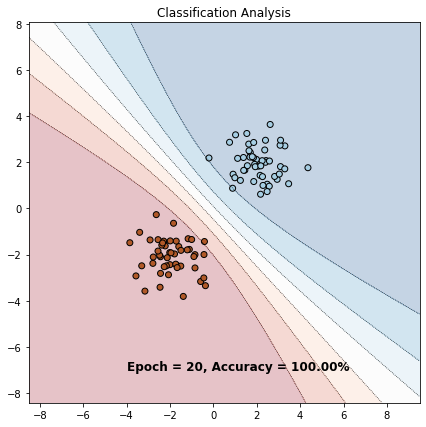

In [19]:
fig, ax = plt.subplots(figsize=(7,7))
pyro.clear_param_store()
logreg = BayesianLogRegModel(D=2)
logreg.infer_parameters(train_dataloader, num_epochs=20, lr=0.1)

**Question 2.5: Same as in previous question 2.3, analyze the results showed on plot. This time, what can you say about points far from train distribution?**

### II.3 MLP with MCDropout variational inference

In the same spirit than II.2, we can leverage the results shown in [[1]](https://arxiv.org/abs/1506.02142) and use MC Dropout variational inference within a MLP.

**Question 2.6: Implement MLP with dropout model by completing code below**

In [95]:
#TO DO: Code MLP with 1 hidden layer and a dropout layer. Be careful, the dropout layer should be also activated 
#during test time.
#(Hint: we may want to look out at F.dropout())

class MLP(nn.Module):
    """ Pytorch MLP for binary classification model with an added dropout layer"""
    def __init__(self, hidden_size):
        super().__init__()
        self.l1=nn.Linear(2,hidden_size)
        self.l2=nn.Linear(hidden_size,1)
        self.relu=nn.ReLU()
    def forward(self, x):
        res=self.l1(x)
        res =self.relu(res)
        res=nn.functional.dropout(res,p=0.25)
        res=self.l2(res)
        return F.sigmoid(res)

In [134]:
bnn = MLP(hidden_size=20)
bnn.train()
criterion = nn.BCELoss()
optimizer_bnn = torch.optim.SGD(bnn.parameters(), lr=0.01, momentum=0.90, nesterov=True, weight_decay=1e-6)

**Question 2.7:  Train MLP with gradient descent for 200 epochs in code below**

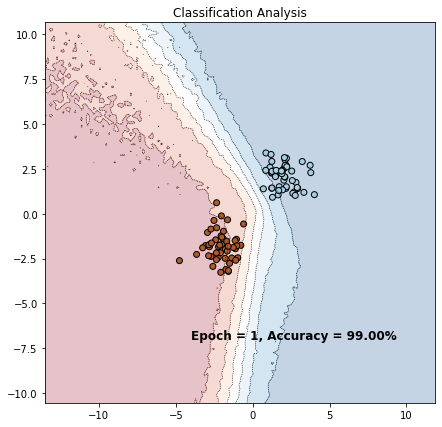

In [140]:
#TO DO: Train MLP for 200 epochs

fig, ax = plt.subplots(figsize=(7,7))
plt.close('all')
for epoch in range(1):
    bnn.train()
    optimizer_bnn.zero_grad()
    pred = bnn(X)
    loss = criterion(pred, y)
    
    loss.backward()
    optimizer_bnn.step()

    if epoch in [0, 1, 2, 3, 4, 9, 19, 49, 99, 199]:
        fig, ax = plt.subplots(figsize=(7,7))
        plot_decision_boundary(bnn, X, y, epoch, ((pred.squeeze()>=0.5) == y).float().mean(), 
                               nbh=10, model_type='mcdropout', samples=100, dbg=0)

**Question 2.8: Again, analyze the results showed on plot. What is the benefit of MC Dropout variational inference over Bayesian Logistic Regression with variational inference?**

## Part III: MC Dropout on MNIST

Finally, we extend this work on more real-world dataset as MNIST. By appling MC Dropout variational inference method, we're interested to obtain an uncertainty measure which can be use to spot the most uncertain images in our dataset.

In [24]:
import torchvision
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets.mnist import MNIST

In [25]:
# Load MNIST dataset
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize((0.1307,),(0.3081,))])
mnist = MNIST(root='images', transform=transform, download=True)
train_set, test_set = random_split(mnist, lengths=(50_000, 10_000))
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

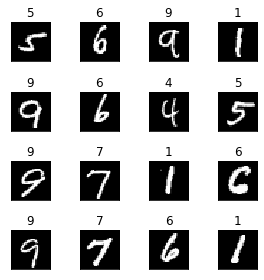

In [26]:
# Visualize some images
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(nrows=4, ncols=4)
for i, (image, label) in enumerate(zip(images, labels)):
    if i >= 16:
        break
    axes[i // 4][i % 4].imshow(images[i][0], cmap='gray')
    axes[i // 4][i % 4].set_title(f"{label}")
    axes[i // 4][i % 4].set_xticks([])
    axes[i // 4][i % 4].set_yticks([])
fig.set_size_inches(4, 4)
fig.tight_layout()

**Question 3.1: Code a LeNet3-style neural network in the following code**

(LeNet3 consists of a first convolutional layer with out_features=32, a second convolutional layer with out_features=64, both equipped with a kernel size of 3. Then, apply a Maxpooling of size 2. After flattening, add 2 linear layers whose hidden size is 128. Dropout layers are located before each one of them, first one with p=0.25, second one p=0.50)

In [27]:
#TO DO: Code a LeNet3-style neural network. Be careful, the dropout layer should be also activated 
#during test time.
#(Hint: we may want to look out at F.dropout())

class LeNet3(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()       
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.MaxPool2d(2))
        
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Linear(64*12*12,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,n_classes))
        
    def forward(self, x):
        x = self.features(x)
        x = x.reshape(-1, 64*12*12)
        x = self.classifier(x)
        return x

In [28]:
lenet = LeNet3(n_classes=10)#.cuda()
lenet.train()
optim_mcdropout = torch.optim.SGD(lenet.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

**Question 3.2:  Train LeNet for 20 epochs in code below**

In [30]:
#TO DO: Train LeNet3 for 20 epochs. You should approach >99% accuracy on train set
criterion = nn.CrossEntropyLoss()

for epoch in range(20):#todo 20 ?
    acc = []
    for i, (batch_x, batch_y) in enumerate(train_loader):
        optim_mcdropout.zero_grad()
        pred = lenet(batch_x)
        loss = criterion(pred, batch_y)
        loss.backward()
        optim_mcdropout.step()
        acc.append((torch.argmax(pred, dim=1) == batch_y).sum() * 1.0/len(pred))
    print("Epoch {} : accuracy = {}%".format(epoch, np.mean(acc) * 100))

Epoch 0 : accuracy = 94.06529664993286%
Epoch 1 : accuracy = 97.46003746986389%
Epoch 2 : accuracy = 98.40632677078247%
Epoch 3 : accuracy = 98.80394339561462%
Epoch 4 : accuracy = 99.00974631309509%
Epoch 5 : accuracy = 99.33063983917236%
Epoch 6 : accuracy = 99.48129653930664%
Epoch 7 : accuracy = 99.51446652412415%
Epoch 8 : accuracy = 99.70228672027588%
Epoch 9 : accuracy = 99.75023865699768%
Epoch 10 : accuracy = 99.80418682098389%
Epoch 11 : accuracy = 99.8781144618988%
Epoch 12 : accuracy = 99.89010691642761%
Epoch 13 : accuracy = 99.92806911468506%
Epoch 14 : accuracy = 99.97402429580688%
Epoch 15 : accuracy = 99.97802376747131%
Epoch 16 : accuracy = 99.98201727867126%
Epoch 17 : accuracy = 99.99001026153564%
Epoch 18 : accuracy = 99.99001026153564%
Epoch 19 : accuracy = 99.99600648880005%


In [31]:
# We predict test set using s=100 samples and entropy as uncertainty measure (see next lesson)
# Verifie here that your model achieves also >99% accuracy on test set

lenet.eval()
lenet.training = True
pred, uncertainty, label = [], [], []
for image, target in test_loader:
    outputs = torch.zeros(100, image.shape[0], 10)
    for i in range(100):
        with torch.no_grad():
            outputs[i] = lenet(image)
    output = outputs.mean(0)
    probs = F.softmax(output, dim=1)
    entropy = (probs * torch.log(probs + 1e-9)).sum(dim=1)  # entropy measure
    pred.extend(probs.max(dim=1, keepdim=True)[1])
    label.extend(target)
    uncertainty.extend(entropy)

pred = np.reshape(pred, newshape=(len(pred), -1)).flatten()
label = np.reshape(label, newshape=(len(label), -1)).flatten()
uncertainty = np.reshape(uncertainty, newshape=(len(uncertainty), -1)).flatten()

print(f'Test set accuracy = {(pred == label).sum()/len(pred):.2%}')

Test set accuracy = 98.96%


In [ ]:
# If you already train your model, you can load it instead using :
lenet.load_state_dict(torch.load('lenet_final_tp2.cpkt'))

In [35]:
#TO DO: Train LeNet3 for 20 epochs. You should approach >99% accuracy on train set
# NB: as the training is long, you may want to save your model after training in case your computer crash
torch.save(lenet.state_dict(), 'lenet_final_tp2.cpkt')

**Question 3.3: Plot the top-9 most uncertain images along with their entropy value, their ground-truth class and prediction class. What do you note when looking at those images?**

6981
9345
5275
7524
5024
7252
9619
3927
7325


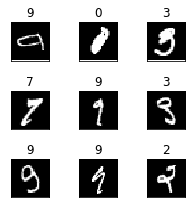

In [34]:
# TO DO: plot top-9 most uncertainy images thanks to the 'uncertainty' vector previously computed
# Visualize some images
top9_ind = np.argsort(uncertainty)[:9]
top9_entropy = uncertainty[top9_ind]
top9_label = label[top9_ind]
top9_pred = pred[top9_ind]
fig, axes = plt.subplots(nrows=3, ncols=3)
for i, (ind, entropy, label, pred) in enumerate(zip(top9_ind, top9_entropy, top9_label, top9_pred)):
    print(ind)
    if i >= 9:
        break
    im = test_set.__getitem__(ind)[0]
    axes[i // 3][i % 3].imshow(im[0], cmap='gray')
    axes[i // 3][i % 3].set_title(label.item())
    axes[i // 3][i % 3].set_xticks([])
    axes[i // 3][i % 3].set_yticks([])
fig.set_size_inches(3, 3)
fig.tight_layout()